# Spatio-Temporal Traffic Forecasting with Neural Graph Cellular Automata
Petrônio C.  L. Silva  <span itemscope itemtype="https://schema.org/Person"><a itemprop="sameAs" content="https://orcid.org/0000-0002-1202-2552" href="https://orcid.org/0000-0002-1202-2552" target="orcid.widget" rel="noopener noreferrer" style="vertical-align:top;"><img src="https://orcid.org/sites/default/files/images/orcid_16x16.png" style="width:1em;margin-right:.5em;" alt="ORCID iD icon"></a></span>, Omid Orang  <span itemscope itemtype="https://schema.org/Person"><a itemprop="sameAs" content="https://orcid.org/0000-0002-4077-3775" href="https://orcid.org/0000-0002-4077-3775" target="orcid.widget" rel="noopener noreferrer" style="vertical-align:top;"><img src="https://orcid.org/sites/default/files/images/orcid_16x16.png" style="width:1em;margin-right:.5em;" alt="ORCID iD icon"></a></span>, Lucas Astore, Frederico G. Guimarães <span itemscope itemtype="https://schema.org/Person"><a itemprop="sameAs" content="https://orcid.org/0000-0001-9238-8839" href="https://orcid.org/0000-0001-9238-8839" target="orcid.widget" rel="noopener noreferrer" style="vertical-align:top;"><img src="https://orcid.org/sites/default/files/images/orcid_16x16.png" style="width:1em;margin-right:.5em;" alt="ORCID iD icon"></a></span>

In case you have any questions, do not hesitate in contact us using the following e-mail: petronio.candido@ifnmg.edu.br


## Imports

In [1]:
from datetime import datetime


import torch
from torch import nn


from st_nca.common import get_device, resume
from st_nca.datasets.PEMS import PEMS03
from st_nca.cellmodel import CellModel
from st_nca.pretrain import training_loop
from st_nca.gca import GraphCellularAutomata



## Data

In [2]:
DEVICE = get_device()
DTYPE = torch.float32

DEFAULT_PATH = 'C:\\Users\\petro\\Dropbox\\Projetos\\futurelab\\posdoc\\st_nca\\st_nca\\st_nca\\'


pems = PEMS03(dtype = DTYPE, device = DEVICE)

In [3]:
sensor_index = 10
sensor = pems.get_sensor(sensor_index)
print(sensor)
sample_index = 10

ds1 = pems.get_sensor_dataset(sensor, dtype=torch.float32, behavior='deterministic')
ds2 = pems.get_allsensors_dataset(behavior='deterministic')

#pems.to_tensordict()


313658


In [40]:
x1,y1 = ds1[sample_index]
x2,y2 = ds2[(ds2.train_split - 1) * sensor_index + 200 ]
print(x1[0])
print(x2[0])
print(y1,y2)

10 313658 200
tensor([-1.2489e-01,  4.0435e-01, -3.2837e-03, -5.3190e-04,  2.4754e+00,
         6.1224e-02, -9.3969e-01])
tensor([-1.2489e-01,  4.0435e-01, -3.2837e-03, -5.3190e-04,  1.0698e+00,
         1.5162e-01, -9.3969e-01], device='cuda:0')
tensor(506.) tensor(317., device='cuda:0')


## Cell Model Training

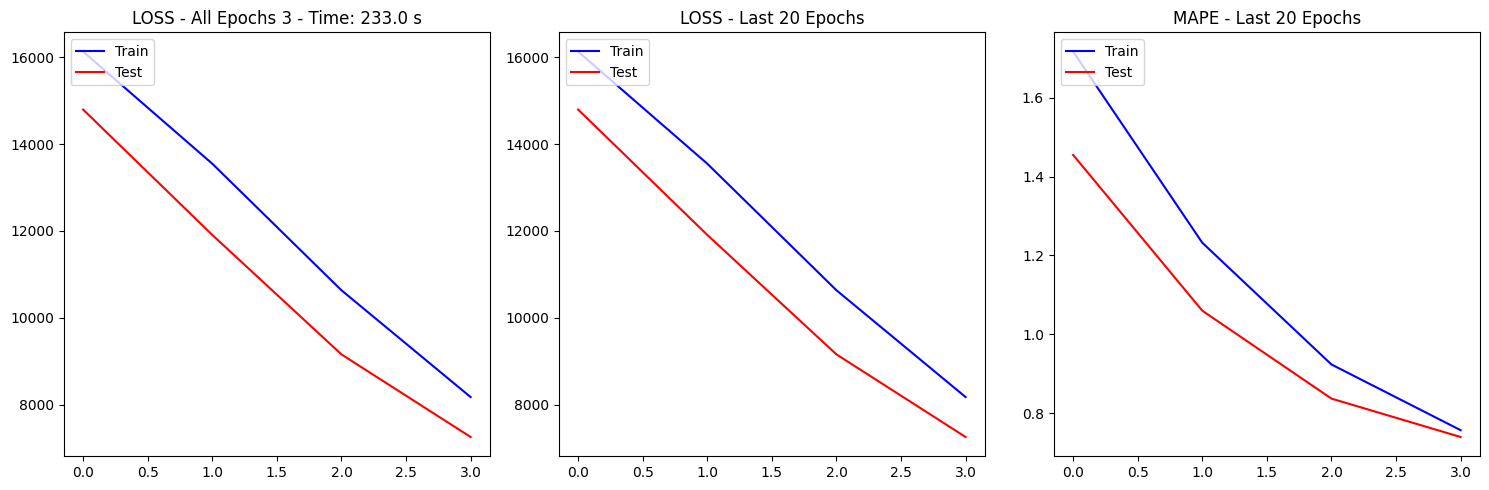

KeyboardInterrupt: 

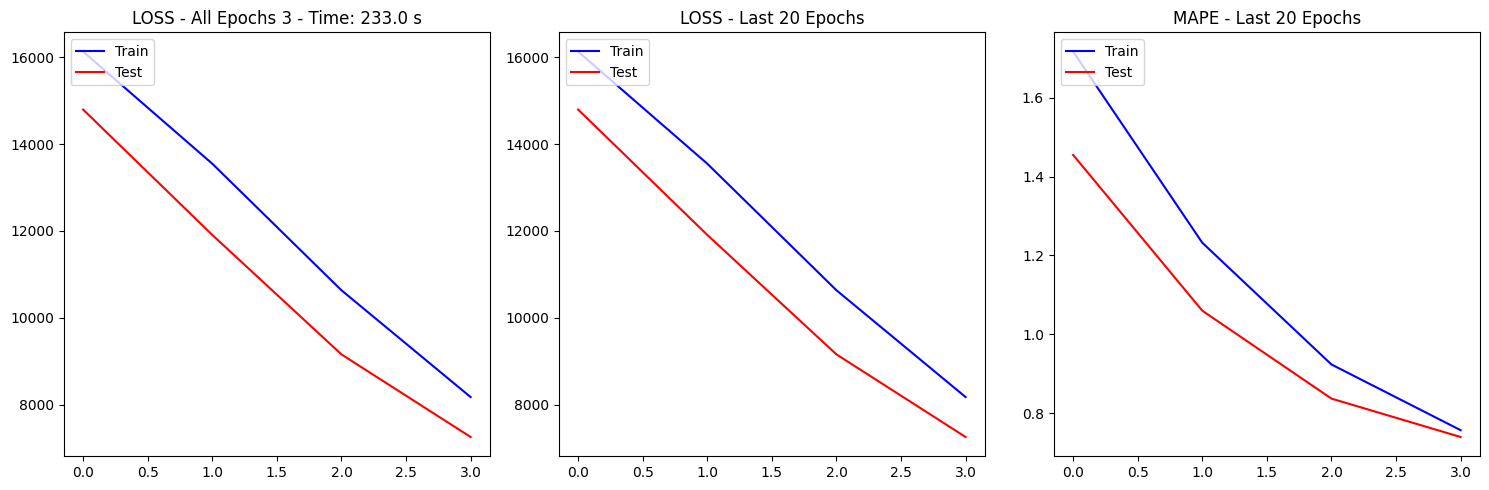

In [5]:
NTRANSF = 1
NHEADS = 16
NTRANSFF = 1024
TRANSFACT = nn.GELU()
MLP = 1
MLPD = 1024
MLPACT = nn.GELU()

MODELS_PATH = DEFAULT_PATH + 'weights\\PEMS03\\'

CHECKPOINT_FILE = MODELS_PATH + 'cell_model_{}_{}_{}_{}_{}.pt'.format(NTRANSF,NHEADS,NTRANSFF,MLP,MLPD)

#ds = pems.get_fewsensors_dataset([311930, 312564, 312807, 312900, 313172, 314697, 315938, 317141, 318135, 318443 ], dtype=torch.float32, behavior='selfsupervised')
#ds = pems.get_sensor_dataset(311930, dtype=torch.float32, behavior='nondeterministic')
ds, sensors = pems.get_breadth_dataset(314697, max_sensors=20, 
                                       dtype=DTYPE,
                                       behavior='selfsupervised')

print(sensors)

#pems.to_tensordict()

#ds = pems.get_allsensors_dataset(behavior='deterministic')

ds = ds.to(DEVICE)

cm = CellModel(num_tokens = ds.max_length, dim_token = ds.token_dim,
               num_transformers = NTRANSF, num_heads = NHEADS, feed_forward = NTRANSFF, 
               transformer_activation = TRANSFACT,
               mlp = MLP, mlp_dim = MLPD, mlp_activation = MLPACT,
               use_moe = False, num_experts = 8,
               device = DEVICE, dtype = DTYPE,
               pre_norm=True, normalization=nn.RMSNorm)

#resume(cm, MODELS_PATH + 'PEMS03_cell_model_2_4_256_2_256_20241214.pt')


#resume(cm, CHECKPOINT_FILE)

training_loop(DEVICE, ds, cm,  batch=2048, epochs=10, lr=0.001,
              checkpoint_file= CHECKPOINT_FILE)

## Evaluation

In [16]:
from st_nca.common import MAPE, SMAPE
def evaluate(model, in_sample, out_sample, num_samples = None):
  metrics = {"MAPE": MAPE, "SMAPE": SMAPE}

  model.eval()

  results = {}

  results['train'] = experiment_on_dataset(model, in_sample, num_samples, metrics)
  results['test'] = experiment_on_dataset(model, out_sample, num_samples, metrics)

  return results

def experiment_on_dataset(model, sample, num_samples, metrics):
    total = len(sample)
    samples = num_samples if not num_samples is None else total
    indexes = torch.randperm(total, device=model.device)[:samples]

    X_batch = torch.zeros(samples, model.num_tokens, model.dim_token, 
                      device=model.device, dtype=model.dtype)
    y_batch = torch.zeros(samples, device=model.device, dtype=model.dtype)
  
    for ct,ix in enumerate(indexes):
      X,y = sample[ix]
      X_batch[ct,:] = X
      y_batch[ct] = y

    #print(X_batch, y_batch)

    out = model(X_batch)

    #print(out)

    res = {}
    for key, metric in metrics.items():
      res[key] = metric(y_batch, out).detach().cpu()

    return res

In [19]:
NTRANSF = 2
NHEADS = 4
NTRANSFF = 256
TRANSFACT = nn.GELU()
MLP = 2
MLPD = 256
MLPACT = nn.GELU()

MODELS_PATH = DEFAULT_PATH + 'weights\\PEMS03\\'

CHECKPOINT_FILE = MODELS_PATH + 'cell_model_{}_{}_{}_{}_{}.pt'.format(NTRANSF,NHEADS,NTRANSFF,MLP,MLPD)

pems.to_tensordict()

ds = pems.get_allsensors_dataset(behavior='selfsupervised')

ds = ds.to(DEVICE)

cm = CellModel(num_tokens = ds.max_length, dim_token = ds.token_dim,
               num_transformers = NTRANSF, num_heads = NHEADS, feed_forward = NTRANSFF, 
               transformer_activation = TRANSFACT,
               mlp = MLP, mlp_dim = MLPD, mlp_activation = MLPACT,
               use_moe = False, num_experts = 8,
               device = DEVICE, dtype = DTYPE)

resume(cm, CHECKPOINT_FILE)

evaluate(model=cm, in_sample=ds.train(), out_sample=ds.test(), num_samples=15000)

{'train': {'MAPE': tensor(2.4232e+08), 'SMAPE': tensor(0.8460)},
 'test': {'MAPE': tensor(2.0427e+08), 'SMAPE': tensor(0.8683)}}

### Experiment Agenda

Federated Graph Neural Cellular Automata - FedGNCA

#### Cross Validation

- 60% Training
- 20% Validation
- 20% Test

#### H = Forecasting Horizons

- ~H = 1 (5 minutes ahead)~
- H = 12 (1 hour ahead)
- ~H = 24 (2 hours ahead)~
- ~H = 48 (4 hours ahead)~
- ~H = 96 (8 hours ahead)~

#### Metrics
- Loss Function: MSE
- Comparison Metrics
  - MAPE 
  - RMSE
  - MAE

In [ ]:
pems.num_samples

## Graph CA

In [ ]:
MODELS_PATH = DEFAULT_PATH + 'weights\\PEMS03\\'

DTYPE = torch.float32
NTRANSF = 2
NHEADS = 4
NTRANSFF = 256
TRANSFACT = nn.GELU()
MLP = 2
MLPD = 256
MLPACT = nn.GELU()

ds, sensors = pems.get_breadth_dataset(314697, max_sensors=20, 
                                       dtype=torch.float64,
                                       behavior='deterministic')

cm = CellModel(num_tokens = ds.max_length, dim_token = ds.token_dim,
               num_transformers = NTRANSF, num_heads = NHEADS, feed_forward = NTRANSFF, 
               transformer_activation = TRANSFACT,
               mlp = MLP, mlp_dim = MLPD, mlp_activation = MLPACT,
               device = DEVICE, dtype = DTYPE)

resume(cm, MODELS_PATH + 'cell_model_{}_{}_{}_{}_{}.pt'.format(NTRANSF,NHEADS,NTRANSFF,MLP,MLPD))

subgraph = pems.G.subgraph(sensors)

gca = GraphCellularAutomata(device=cm.device, dtype=cm.dtype, graph = subgraph,
                            max_length = pems.max_length, token_size=pems.token_dim,
                            tokenizer=pems.tokenizer, cell_model = cm)

initial_date = datetime(year=2018, month=9, day=1, hour=23, minute=0)

df = pems.data[(pems.data['timestamp'] == from_datetime_to_np(initial_date))]

initial_state = {}
for sensor in subgraph.nodes():
    initial_state[str(sensor)] = df[str(sensor)].values[0]

print(initial_state)

gca.run(initial_date = initial_date, initial_stat = initial_state, 
        iterations = 10, increment_type='minute', increment=5,
        return_type = 'tensordict')



## Fine Tunning

In [ ]:
from st_nca.finetune import FineTunningDataset, finetune_loop

MODELS_PATH = DEFAULT_PATH + 'weights\\PEMS03\\'

DTYPE = torch.float32
NTRANSF = 2
NHEADS = 4
NTRANSFF = 256
TRANSFACT = nn.GELU()
MLP = 2
MLPD = 256
MLPACT = nn.GELU()

ds, sensors = pems.get_breadth_dataset(314697, max_sensors=20, 
                                       dtype=DTYPE,
                                       behavior='deterministic')

cm = CellModel(num_tokens = ds.max_length, dim_token = ds.token_dim,
               num_transformers = NTRANSF, num_heads = NHEADS, feed_forward = NTRANSFF, 
               transformer_activation = TRANSFACT,
               mlp = MLP, mlp_dim = MLPD, mlp_activation = MLPACT,
               device = DEVICE, dtype = DTYPE)

resume(cm, MODELS_PATH + 'cell_model_{}_{}_{}_{}_{}.pt'.format(NTRANSF,NHEADS,NTRANSFF,MLP,MLPD))

subgraph = pems.G.subgraph(sensors)

gca = GraphCellularAutomata(device=DEVICE, dtype=DTYPE, graph = subgraph,
                            max_length = pems.max_length, token_size=pems.token_dim,
                            tokenizer=pems.tokenizer, cell_model = cm)

finetune_ds = FineTunningDataset(pems, sensors, )

finetune_loop(DEVICE, finetune_ds, gca, 
              iterations = 10, increment_type='minute', increment=5,
              epochs = 10, batch = 50, lr = 0.0001,
              checkpoint_file =  MODELS_PATH + 'gca_{}_{}_{}_{}_{}.pt'.format(NTRANSF,NHEADS,NTRANSFF,MLP,MLPD))

In [ ]:
pems.num_samples